# Loading and Understanding Data

Before loading the data, we imported releavnt python modules as you can see in the first snippet of my code. For instance, to load our data-frame using CSV file, we imported the library ‘pandas’. Once we had the data loaded, we tried understanding the data by printing the first few lines of the data frame using data.head() command.

In [22]:
# import relevant modules
import pandas as pd
import numpy as np
import math
import datetime

# Machine Learning
from sklearn import preprocessing, model_selection
from sklearn.linear_model import LinearRegression,ElasticNet

#Visualization
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

In [23]:
df = pd.read_csv("C:/Users/parashk/Desktop/Jupyter/TCS_Data.csv")
df.set_index('Date', inplace=True)
df.dropna(inplace=True)

# Getting a peek into data 
# I am using round function to see only upto 2 decimal digits
print(df.head(2).round(2))
print('\n')

# Also print columns and index
print(df.columns)
print(df.index)

              Open    High     Low   Close  Adj Close      Volume
Date                                                             
2004-08-25  149.84  149.84  122.38  123.49      67.23    136928.0
2004-08-26  124.00  124.62  121.91  122.38      66.62  40443200.0


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['2004-08-25', '2004-08-26', '2004-08-27', '2004-08-30', '2004-08-31',
       '2004-09-01', '2004-09-02', '2004-09-03', '2004-09-06', '2004-09-07',
       ...
       '2019-02-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07',
       '2019-02-08', '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14'],
      dtype='object', name='Date', length=3573)


# Feature Engineering

Before getting into feature engineering, we noticed that the data had very similar features such as Close and Adj Close. These features only differ if stock-split or merge happens. we also discarded any other column that we thought weren’t that important (Adj Close). 

We refined features further based on general understanding of financial data. For instance, instead of dealing with High and Low separately, we created volatility percentages as our new features as shown below:

In [24]:
# Discarding features that aren't useful
df = df[['Open','High', 'Low', 'Close', 'Volume']]

# define a new feature, HL_PCT
df['HL_PCT'] = (df['High'] - df['Low'])/(df['Low']*100)

# define a new feature percentage change
df['PCT_CHNG'] = (df['Close'] - df['Open'])/(df['Open']*100)

df = df[['Close', 'HL_PCT', 'PCT_CHNG', 'Volume']]


dataset = df[['Close', 'HL_PCT', 'PCT_CHNG', 'Volume']]
print(df.head(1))
print(dataset.head(1))

                 Close    HL_PCT  PCT_CHNG    Volume
Date                                                
2004-08-25  123.494003  0.002244 -0.001758  136928.0
                 Close    HL_PCT  PCT_CHNG    Volume
Date                                                
2004-08-25  123.494003  0.002244 -0.001758  136928.0


We plotted our features as a function of dates, which are saved in the index of our data frame. Since the shares prices are almost linearly rising with time, linear regression should give us a reasonably good prediction!

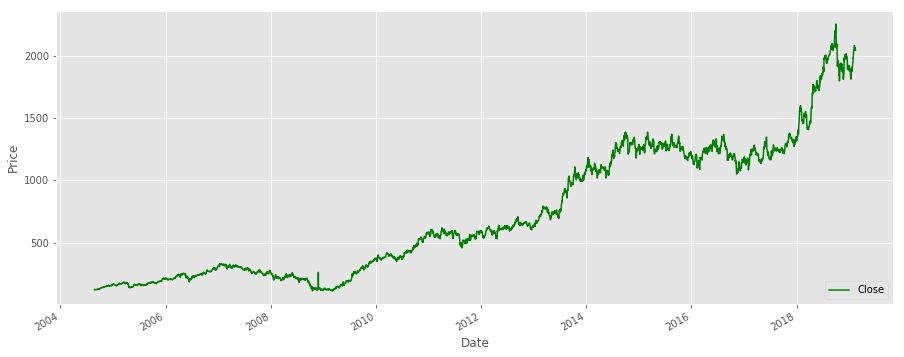

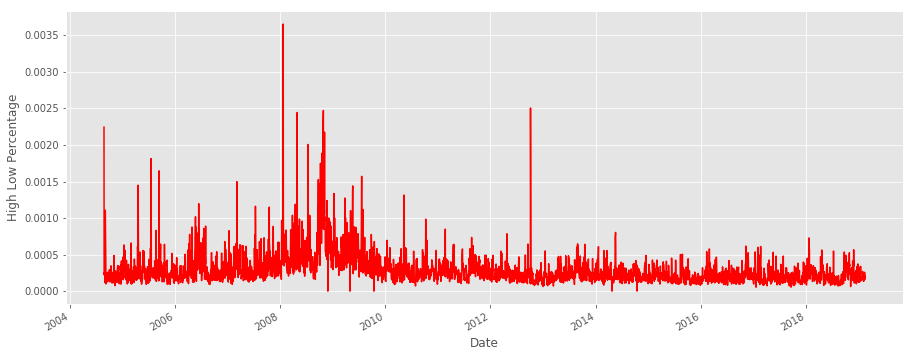

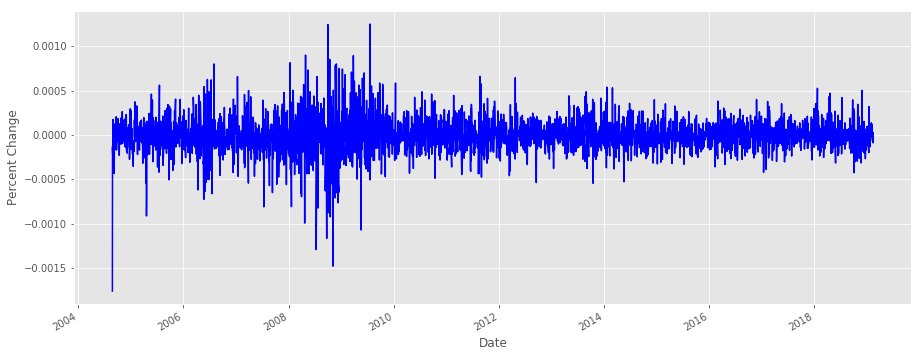

In [25]:
#To register the converters
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#setting index as date
dataset['Date'] = pd.to_datetime(dataset.index,format='%Y-%m-%d')
dataset.index = dataset['Date']

dataset['Close'].plot(figsize=(15,6), color="green")
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

dataset['HL_PCT'].plot(figsize=(15,6), color="red")
plt.xlabel('Date')
plt.ylabel('High Low Percentage')
plt.show()

dataset['PCT_CHNG'].plot(figsize=(15,6), color="blue")
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.show()

# Machine Learning

# Creating Features and Label

We chose the forecast of close, forecast_out after next 30 days for my label (the entity that we want to predict). This is completely flexible, the smaller the value of forecast_out, more accurate would be the model. An important thing to note here is that once we have shifted our data according to number of days in forecast (say n) to create our column ‘label’, we will end up with Nan’s in last n rows of column ‘label’. 

In [26]:
# pick a forecast column
forecast_col = 'Close'

# Chosing 30 days as number of forecast days
forecast_out = int(30)
print('length =',len(df), "and forecast_out =", forecast_out)

length = 3573 and forecast_out = 30


In [27]:
# Creating label by shifting 'Adj. Close' according to 'forecast_out'
df['label'] = df[forecast_col].shift(-forecast_out)
print(df.head(2))
print('\n')
# If we look at the tail, it consists of n(=forecast_out) rows with NAN in Label column 
print(df.tail(2))

                 Close    HL_PCT  PCT_CHNG      Volume       label
Date                                                              
2004-08-25  123.494003  0.002244 -0.001758    136928.0  135.199997
2004-08-26  122.375000  0.000223 -0.000131  40443200.0  137.136993


                  Close    HL_PCT  PCT_CHNG     Volume  label
Date                                                         
2019-02-13  2065.399902  0.000158  0.000016  2808581.0    NaN
2019-02-14  2044.599976  0.000206 -0.000075  1724085.0    NaN


In [28]:
# Define features Matrix X by excluding the label column which we just created 
X = np.array(df.drop(['label'], 1))

# Using a feature in sklearn, preposessing to scale features
X = preprocessing.scale(X)
print(X[1,:])

[-1.1599822  -0.30539912 -0.64092678 10.57434087]


In [29]:
# X contains last 'n= forecast_out' rows for which we don't have label data
# Put those rows in different Matrix X_forecast_out by X_forecast_out = X[end-forecast_out:end]

X_forecast_out = X[-forecast_out:]
X = X[:-forecast_out]
print ("Length of X_forecast_out:", len(X_forecast_out), "& Length of X :", len(X))

Length of X_forecast_out: 30 & Length of X : 3543


In [30]:
# Similarly Define Label vector y for the data we have prediction for
# A good test is to make sure length of X and y are identical
y = np.array(df['label'])
y = y[:-forecast_out]
print('Length of y: ',len(y))

Length of y:  3543


# Regression

Finally, we try out certain Regression algorithms on our data set by dividing it into train and test data.

# Creating Training and Test Sets

Using model selection basically shuffles the data and according to our test_size criteria, splits the data into test and training data.

In [31]:
# Model selection (split into test and train data)
# test_size = 0.3 ==> 30% data is test data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3)

print('length of X_train and x_test: ', len(X_train), len(X_test))

length of X_train and x_test:  2480 1063


# Training and testing

Now it’s time to use certain regression algorithms. we first Split the data into 70% of training data and 30% of test data. We then, used certain regression algorithms to train and test data. Finally, we tested the accuracy of our model on the test data.

1. Train model using Decision Tree Model

In [32]:
# Train model using Decision Tree Model

from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(min_samples_leaf = 200)

dtr.fit(X_train, y_train)

#print(dt.predict(test))
dtrScore = dtr.score(X_test, y_test)

print("Accuracy of Decision Tree Regression: ", dtrScore)

Accuracy of Decision Tree Regression:  0.970590600411619


2. Train model using Lasso Regression Model

In [33]:
# Train model using Lasso Regression Model

from sklearn import linear_model
from sklearn.linear_model import ElasticNet

clf = linear_model.Lasso(alpha = 26)
clf.fit(X_train,y_train)

#print(dt.predict(test))
lassoScore = clf.score(X_test, y_test)

print("Accuracy of Lasso Regression: ", lassoScore)

Accuracy of Lasso Regression:  0.9832722016451517


3. Train model using Linear Regression Model

In [34]:
# Train model using Linear Regression Model

clf = LinearRegression()
clf.fit(X_train,y_train)
# Test
accuracy = clf.score(X_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)

Accuracy of Linear Regression:  0.9861925593632059


# Prediction

It seems like this Linear Regression model did fairly well on the test data set! Now we can go ahead and use this model to predict prices of shares for the next 30 days.

In [35]:
# Predict using our Linear Regression Model
forecast_prediction = clf.predict(X_forecast_out)
print(forecast_prediction)

[1906.53510795 1924.71736943 1921.34272853 1914.50436944 1917.0436365
 1880.04653247 1843.15287467 1897.3635176  1897.64120271 1921.61984118
 1926.47608324 1935.90343588 1930.19793114 1904.43412192 1927.82085625
 1947.50247561 1982.42698176 2009.43986963 2009.86919178 2043.93095655
 2058.81292545 2077.56392379 2072.74922346 2101.77444977 2110.98059513
 2090.4210208  2093.67619066 2081.04977091 2095.45984403 2073.39374051]


We then plot the predicted prices as a function of dates. The piece of code below just adds dates for the predicted days.

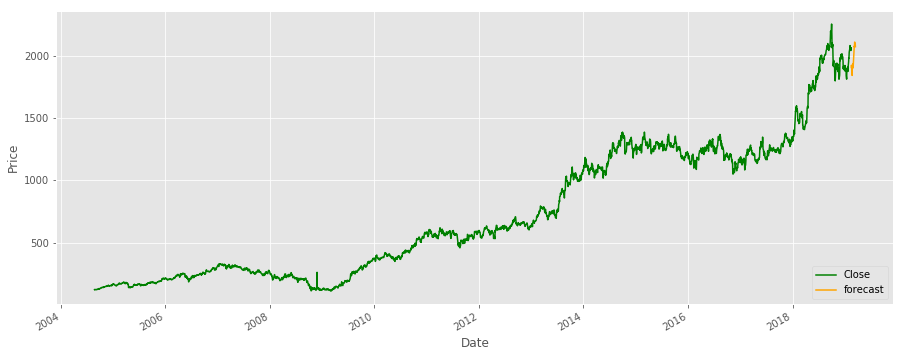

In [36]:
# Plotting data
dataset.dropna(inplace=True)
dataset['forecast'] = np.nan
last_date = dataset.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_prediction:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    dataset.loc[next_date] = [np.nan for _ in range(len(dataset.columns)-1)]+[i]
dataset['Close'].plot(figsize=(15,6), color="green")
dataset['forecast'].plot(figsize=(15,6), color="orange")
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


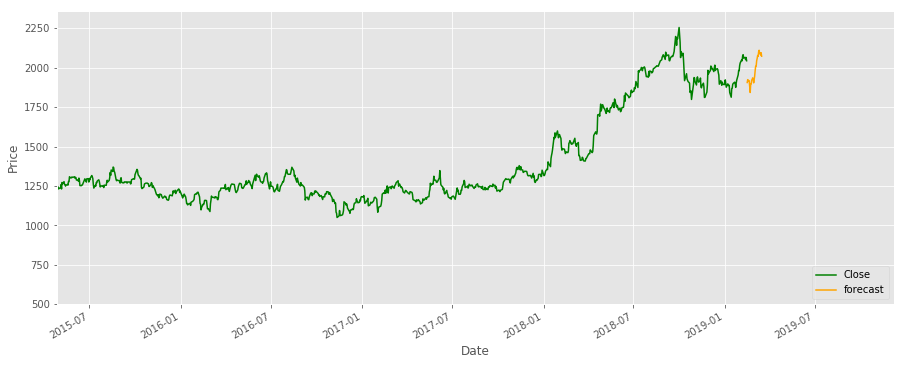

In [37]:
# Zoomed In to a year
dataset['Close'].plot(figsize=(15,6), color="green")
dataset['forecast'].plot(figsize=(15,6), color="orange")
plt.xlim(xmin=datetime.date(2015, 4, 26))
plt.ylim(ymin=500)
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

There it is! The prediction of stock prices for the next 30 days, by using linear regression.